# Get AQI data

In this notebook, we get the AQI data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The US EPA was created in the early 1970's. The EPA reports that they only started broad based monitoring with standardized quality assurance procedures in the 1980's. Many counties will have data starting somewhere between 1983 and 1988. However, some counties still do not have any air quality monitoring stations. The API helps resolve this by providing calls to search for monitoring stations and data using either station ids, or a county designation or a geographic bounding box. This example code provides examples of the county based and bounding box based API calls.

Note - This code example extended by the code snippets developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024


Here, we load the necessary packages that we'll be using to manipulate, modify and wrangle the data with. We will also import some packages that will help us with computing correlation and fitting data to predict future values. Install necessary libraries as and when required using `%pip install package_name`.

In [ ]:
# %pip install matplotlib

In [ ]:
import json, time
import requests
import pandas as pd
from pyproj import Geod
import matplotlib.pyplot as plt


Note - this analysis was done in Google Colab, which is a Jupyter Notebook setup that runs in cloud. It gets the data files from your Google Drive, for which it requires the below snipped works by making the data files available in Google Drive. Change to the required path where all the data files are located. This will differ for each user.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/data 512/week 4'

/content/drive/MyDrive/data 512/week 4


We're grabbing the client secrets from Google Colab's user data. This way, we can securely use the ORES service without hardcoding sensitive information.

In [ ]:
from google.colab import userdata
UW_EMAIL = userdata.get('UW_EMAIL')

In [ ]:
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
#
AQS_REQUEST_TEMPLATE = {
    "email":      "",
    "key":        "",
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



Making a sign-up request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.

In [ ]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL,
                   endpoint_action = API_ACTION_SIGNUP,
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):

    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address

    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']:
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [ ]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
# print("Requesting SIGNUP ...")
# response = request_signup(UW_EMAIL)
# print(json.dumps(response, indent=4))


A response to the signup request might look something like this.


    Requesting SIGNUP ...
    {
        "Header": [
            {
                "status": "Success",
                "request_time": "2023-08-07T17:03:27-04:00",
                "url": "https://aqs.epa.gov/data/api/signup?email=dwmc@uw.edu"
            }
        ],
        "Data": [
            "You should receive a registration confirmation email with a link for confirming your email shortly."
        ]
    }



Once we have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms.

In [ ]:
AQI_USERID = userdata.get('AQI_USERID')
AQI_KEY = userdata.get('AQI_KEY')


In [ ]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL,
                      endpoint_action = API_ACTION_LIST_CLASSES,
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):

    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key

    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [ ]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#

# Define the constants
AQI_PARAM_CLASS = "AQI POLLUTANTS"
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = AQI_USERID
request_data['key'] = AQI_KEY
request_data['pclass'] = AQI_PARAM_CLASS

# Make the API request
response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


These are the pollutants we will be keeping track of.

In [ ]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.

#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"

#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

To get the FIPS code for our city and county, we make use of the reference link - https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

In [ ]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATION = {
    'city'   : 'Arlington',
    'county' : 'Tarrant',
    'state'  : 'Texas',
    'fips'   : '48439',
    'latlon' : [32.705, -97.122778]
}

Using the below snippet, we will get a list of all air quality monitoring stations around our city.

In [ ]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#

# Define constants
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = AQI_USERID
request_data['key'] = AQI_KEY
request_data['state'] = CITY_LOCATION['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATION['fips'][2:]  # the last three digits (characters) of FIPS is the county code

# Make the API request
response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented": null
    },
    

Since we have enough stations around us, we go ahead and get the data for our required years, and pollutants. We use the below function to define our request, and make requests for each year in the code block below that.

In [ ]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date.
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL,
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY,
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):

    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']:
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']:
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']:
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        # if API_THROTTLE_WAIT > 0.0:
        #     time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



Uncomment the below block and run it to fetch the data. No need to in the current project repository, it is stored in the `intermediate` folder.

In [ ]:

# request_data = AQS_REQUEST_TEMPLATE.copy()
# request_data['email'] = AQI_USERID
# request_data['key'] = AQI_KEY
# request_data['state'] = CITY_LOCATION['fips'][:2]
# request_data['county'] = CITY_LOCATION['fips'][2:]

# # request daily AQI summary data for 1961 to 2024 (May 1st to Oct 31st)
# request_data['param'] = AQI_PARAMS_GASEOUS
# START_YEAR = 1961
# END_YEAR = 2024

# gaseous_aqi = []
# particulate_aqi = []
# gaseous_errors = []
# particulate_errors = []

# for year in range(START_YEAR, END_YEAR + 1):
#     year = str(year)
#     request_data['begin_date'] = f"{year}0501"
#     request_data['end_date'] = f"{year}1031"

#     # Get Gaseous data
#     gaseous_response = request_daily_summary(request_template=request_data)
#     if gaseous_response["Header"][0]['status'] == "Success":
#         # gaseous_aqi[year] = gaseous_response['Data']
#         gaseous_aqi.extend(gaseous_response['Data'])
#     # else:
#     #     gaseous_aqi[year] = []
#     #     gaseous_errors[year] = "No data / API errors"

#     # Get Particulates data
#     request_data_particulates = request_data.copy()
#     request_data_particulates['param'] = AQI_PARAMS_PARTICULATES
#     # print(request_data_particulates)
#     particulate_response = request_daily_summary(request_template=request_data_particulates)
#     if particulate_response["Header"][0]['status'] == "Success":
#         # particulate_aqi[year] = particulate_response['Data']
#         particulate_aqi.extend(particulate_response['Data'])
#     # else:
#     #     particulate_aqi[year] = []
#     #     particulate_errors[year] = "No data / API errors"


In [ ]:
# # Utility function to write the data to JSON
# def write_to_json(filename, data):
#     with open(filename, 'w') as f:
#         json.dump(data, f, indent=4)
#         print(f"{filename} created successfully!")

# # This writes the files to the same folder that the code is structured in. If
# # you want to change the path, make sure you provide the right path.
# write_to_json('gaseous_aqi_response.json', gaseous_aqi)
# write_to_json('particulate_aqi_response.json', particulate_aqi)

## EDA for the AQI data
The raw data will require heavy processing to be fit for use in prediction tasks. We will perform all the required cleaning here.

In [ ]:
# Function to load the JSON data
def load_json(filename):
    """Loads a JSON file from the given filename.

    Args:
        filename (str): The name of the JSON file to load.

    Returns:
        dict: The contents of the JSON file as a Python dictionary.
    """
    with open(filename, 'r') as f:
        return json.load(f)

gaseous_aqi = load_json('gaseous_aqi_response.json')
particulate_aqi = load_json('particulate_aqi_response.json')

Look at the sample response.

In [ ]:
particulate_aqi[0]

{'state_code': '48',
 'county_code': '439',
 'site_number': '0060',
 'parameter_code': '81102',
 'poc': 1,
 'latitude': 32.728187,
 'longitude': -97.413075,
 'datum': 'WGS84',
 'parameter': 'PM10 Total 0-10um STP',
 'sample_duration_code': '7',
 'sample_duration': '24 HOUR',
 'pollutant_standard': 'PM10 24-hour 2006',
 'date_local': '1985-05-01',
 'units_of_measure': 'Micrograms/cubic meter (25 C)',
 'event_type': 'No Events',
 'observation_count': 1,
 'observation_percent': 100.0,
 'validity_indicator': 'Y',
 'arithmetic_mean': 23.0,
 'first_max_value': 23.0,
 'first_max_hour': 0,
 'aqi': 21,
 'method_code': '073',
 'method': 'LO-VOL-DICHOTOMOUS-SA246B-INLT - GRAVIMETRIC',
 'local_site_name': 'NE OF DIAZ AVE & GUILFORD RD. INTERSECTION',
 'site_address': '5933 GEDDES',
 'state': 'Texas',
 'county': 'Tarrant',
 'city': 'Fort Worth',
 'cbsa_code': '19100',
 'cbsa': 'Dallas-Fort Worth-Arlington, TX',
 'date_of_last_change': '2024-05-22'}

Here, we load it into a dataframe for easier handling and cleaning.

In [ ]:
df_gaseous = pd.DataFrame(gaseous_aqi)
df_particulate = pd.DataFrame(particulate_aqi)

In [ ]:
df_gaseous.head(2)

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,48,439,2001,42401,1,32.750408,-97.333905,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"1000 THROCKMORTON, CITY HALL ROOF",Texas,Tarrant,Fort Worth,19100,"Dallas-Fort Worth-Arlington, TX",2013-06-11
1,48,439,2001,42401,1,32.750408,-97.333905,WGS84,Sulfur dioxide,7,...,091,GAS-BUBBLER - PARAROSANILINE-SULFAMIC ACID,None,"1000 THROCKMORTON, CITY HALL ROOF",Texas,Tarrant,Fort Worth,19100,"Dallas-Fort Worth-Arlington, TX",2013-06-11


In [ ]:
df_particulate.head(2)

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,48,439,0060,81102,1,32.728187,-97.413075,WGS84,PM10 Total 0-10um STP,7,...,073,LO-VOL-DICHOTOMOUS-SA246B-INLT - GRAVIMETRIC,NE OF DIAZ AVE & GUILFORD RD. INTERSECTION,5933 GEDDES,Texas,Tarrant,Fort Worth,19100,"Dallas-Fort Worth-Arlington, TX",2024-05-22
1,48,439,0060,81102,1,32.728187,-97.413075,WGS84,PM10 Total 0-10um STP,7,...,073,LO-VOL-DICHOTOMOUS-SA246B-INLT - GRAVIMETRIC,NE OF DIAZ AVE & GUILFORD RD. INTERSECTION,5933 GEDDES,Texas,Tarrant,Fort Worth,19100,"Dallas-Fort Worth-Arlington, TX",2024-05-22


We do a little bit of EDA and explore what type of values are present...

In [ ]:
df_gaseous.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [ ]:
df_particulate.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [ ]:
column_names = ["state_code", "county_code", "site_number", "parameter_code",
                "latitude", "longitude", "parameter", "sample_duration",
                "date_local", "units_of_measure",
                "aqi", "arithmetic_mean",
                "first_max_value", "validity_indicator"]

print("No. of rows in df_gaseous - ", len(df_gaseous))
df_gaseous = df_gaseous[column_names]
df_gaseous = df_gaseous.drop_duplicates()
print("No. of rows in df_gaseous after dropping duplicates - ", len(df_gaseous))

print("No. of rows in df_particulate - ", len(df_particulate))
df_particulate = df_particulate[column_names]
df_particulate = df_particulate.drop_duplicates()
print("No. of rows in df_particulate after dropping duplicates - ", len(df_particulate))

No. of rows in df_gaseous -  215918
No. of rows in df_gaseous after dropping duplicates -  157699
No. of rows in df_particulate -  92535
No. of rows in df_particulate after dropping duplicates -  25541


In [ ]:
df_aqi = pd.concat([df_gaseous, df_particulate], axis=0)
# Add a new column `id` with unique id (increasing numbers)
df_aqi.insert(0, "id", range(1, len(df_aqi) + 1))
df_aqi


,id,state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,aqi,arithmetic_mean,first_max_value,validity_indicator
0,1,48,439,2001,42401,32.750408,-97.333905,Sulfur dioxide,24 HOUR,1968-05-11,Parts per billion,NaN,1.500000,1.5,Y
1,2,48,439,2001,42401,32.750408,-97.333905,Sulfur dioxide,24 HOUR,1968-05-22,Parts per billion,NaN,1.500000,1.5,Y
2,3,48,439,2001,42401,32.750408,-97.333905,Sulfur dioxide,24 HOUR,1968-06-06,Parts per billion,NaN,0.700000,0.7,Y
3,4,48,439,2001,42401,32.750408,-97.333905,Sulfur dioxide,24 HOUR,1968-06-23,Parts per billion,NaN,1.500000,1.5,Y
4,5,48,439,2001,42401,32.750408,-97.333905,Sulfur dioxide,24 HOUR,1968-07-13,Parts per billion,NaN,1.500000,1.5,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92509,183236,48,439,1053,88101,32.664753,-97.337917,PM2.5 - Local Conditions,24-HR BLK AVG,2024-06-28,Micrograms/cubic meter (LC),53.0,10.100000,10.1,Y
92517,183237,48,439,1053,88101,32.664753,-97.337917,PM2.5 - Local Conditions,1 HOUR,2024-06-29,Micrograms/cubic meter (LC),NaN,11.541667,19.0,Y
92518,183238,48,439,1053,88101,32.664753,-97.337917,PM2.5 - Local Conditions,24-HR BLK AVG,2024-06-29,Micrograms/cubic meter (LC),55.0,11.500000,11.5,Y
92526,183239,48,439,1053,88101,32.664753,-97.337917,PM2.5 - Local Conditions,1 HOUR,2024-06-30,Micrograms/cubic meter (LC),NaN,8.333333,19.0,Y


We try to find out all the unique stations present near our city.

In [ ]:
site_columns = ["state_code", "county_code", "site_number", "latitude", "longitude"]
unique_stations = df_aqi[site_columns].drop_duplicates().reset_index(drop=True)

# We see that all the sites are from the same state/county, so removing that
unique_stations = unique_stations.drop(columns=["state_code", "county_code"])

print(f"Number of unique stations - {len(unique_stations)}")
unique_stations

Number of unique stations - 27


,site_number,latitude,longitude
0,2001,32.750408,-97.333905
1,0004,32.750000,-97.053889
2,3001,32.950556,-97.055556
3,1002,32.805810,-97.356529
4,1003,32.759722,-97.328056
5,1001,32.841389,-97.098056
6,0006,32.803056,-97.383333
7,0022,32.755000,-97.329722
8,0021,32.716111,-97.335000
9,0005,32.663889,-97.100000


And here, we find the distance between our city and each measuring station. This will be used later to calculate weighted average for our smoke estimates.

In [ ]:
# Standard geo model to calculate distances between two places
geodcalc = Geod(ellps='WGS84')

# Calculate the distance between 2 locations
def distance_in_miles(row):
    d = geodcalc.inv(
        CITY_LOCATION["latlon"][1],
        CITY_LOCATION["latlon"][0],
        row["longitude"],
        row["latitude"]
    )
    # convert the distance to miles
    distance_in_miles = d[2] * 0.00062137
    return distance_in_miles

# Create a new column in unique_stations to find the distance from our city
unique_stations["distance_from_city"] = unique_stations.apply(distance_in_miles, axis=1)

# Sort the dataframe based on distance_from_city
unique_stations = (
    unique_stations
      .sort_values(by="distance_from_city")
      .reset_index(drop=True)
)
unique_stations

,site_number,latitude,longitude,distance_from_city
0,0057,32.706944,-97.093611,1.704567
1,0005,32.663889,-97.100000,3.128486
2,3011,32.656370,-97.088598,3.898371
3,0004,32.750000,-97.053889,5.071145
4,3006,32.693056,-97.248611,7.377760
5,3007,32.831900,-97.066100,9.346574
6,0029,32.831389,-97.063889,9.360021
7,1001,32.841389,-97.098056,9.508153
8,0023,32.695278,-97.321944,11.623659
9,0070,32.675556,-97.323056,11.845470


We inpsect the unique particles and their codes

In [ ]:
(
    df_aqi[['parameter', 'parameter_code']]
      .drop_duplicates()
      .sort_values(by=['parameter'])
      .reset_index(drop=True)
)

,parameter,parameter_code
0,Acceptable PM2.5 AQI & Speciation Mass,88502
1,Carbon monoxide,42101
2,Nitrogen dioxide (NO2),42602
3,Ozone,44201
4,PM10 Total 0-10um STP,81102
5,PM2.5 - Local Conditions,88101
6,Sulfur dioxide,42401


In [ ]:
unique_pollutants_with_duration = (
    df_aqi[['parameter', 'parameter_code', 'sample_duration']]
      .drop_duplicates()
      .sort_values(by=['parameter'])
      .reset_index(drop=True)
)
unique_pollutants_with_duration

,parameter,parameter_code,sample_duration
0,Acceptable PM2.5 AQI & Speciation Mass,88502,1 HOUR
1,Acceptable PM2.5 AQI & Speciation Mass,88502,24-HR BLK AVG
2,Carbon monoxide,42101,1 HOUR
3,Carbon monoxide,42101,8-HR RUN AVG END HOUR
4,Nitrogen dioxide (NO2),42602,24 HOUR
5,Nitrogen dioxide (NO2),42602,1 HOUR
6,Ozone,44201,1 HOUR
7,Ozone,44201,8-HR RUN AVG BEGIN HOUR
8,PM10 Total 0-10um STP,81102,24 HOUR
9,PM2.5 - Local Conditions,88101,24 HOUR


The `date_local` column is in strings, so we deserialize it and parse it in date-time format using `pandas` library.

In [ ]:
# Convert date_local to datetime format
df_aqi['date_local'] = pd.to_datetime(df_aqi['date_local'])

# Check how many readings you have every year
# df_aqi.groupby(df_aqi['date_local'].dt.to_period('M')).size().reset_index().rename(columns={0: 'Count of AQI sensor readings'})
df_aqi.groupby(df_aqi['date_local'].dt.to_period('Y')).size().reset_index().rename(columns={0: 'Count of AQI sensor readings'})

,date_local,Count of AQI sensor readings
0,1968,13
1,1969,12
2,1970,12
3,1971,12
4,1972,15
5,1973,51
6,1974,74
7,1975,94
8,1976,2182
9,1977,2809


We check the three values provided to see which one has missing values.

In [ ]:
# Check which value has the least percent of missing values in the data
columns = ["aqi", "first_max_value", "arithmetic_mean"]
for col in columns:
    percent = df_aqi[col].isna().sum() / len(df_aqi)
    print(f"{round(percent, 2)}% of values are missing in `{col}`.")

0.34% of values are missing in `aqi`.
0.0% of values are missing in `first_max_value`.
0.0% of values are missing in `arithmetic_mean`.


## Cleaning the AQI data
Based on our EDA and exploration, we clean the data here so that it is fit for later analysis steps.

First, we start by aggregating the AQI value. We do it in the following steps -
1. date - station -  particle - multiple aqis (raw data - we start here)
2. date - stattion - particle - single aqi (mean)
3. date - station - single aqi (max)
4. year - aqi (weighted avegrage based on stations distance)

In [ ]:
# 2. Daily AQI per Pollutant for Each Station
df_aqi_daily_per_pollutant_per_station = (
    df_aqi
      # select rows for which aqi value is not null and where validity indicator is 'Y'
      .loc[(df_aqi['validity_indicator'] == "Y") & (df_aqi['aqi'].notnull())]
      .groupby(['date_local', 'site_number', 'parameter_code'])
      .agg({'aqi': 'mean'})
      .reset_index()
)
df_aqi_daily_per_pollutant_per_station

,date_local,site_number,parameter_code,aqi
0,1976-05-01,1002,42101,3.0
1,1976-05-01,1002,42401,0.0
2,1976-05-01,1002,42602,38.0
3,1976-05-02,1002,42101,13.0
4,1976-05-02,1002,42401,0.0
...,...,...,...,...
85541,2024-06-30,3009,42602,5.0
85542,2024-06-30,3009,44201,32.0
85543,2024-06-30,3011,42602,3.0
85544,2024-06-30,3011,44201,16.0


In [ ]:
# 3. Daily AQI for Each Station by finding the max AQI across all pollutants on that day
df_aqi_daily_per_station = (
    df_aqi_daily_per_pollutant_per_station
      .groupby(['date_local', 'site_number'])
      .agg({'aqi': 'max'})
      .reset_index()
)
df_aqi_daily_per_station

,date_local,site_number,aqi
0,1976-05-01,1002,38.0
1,1976-05-02,1002,57.0
2,1976-05-08,1002,57.0
3,1976-05-09,1002,47.0
4,1976-05-10,1002,47.0
...,...,...,...
43034,2024-06-30,1053,45.5
43035,2024-06-30,2003,3.0
43036,2024-06-30,3009,32.0
43037,2024-06-30,3011,16.0


In [ ]:
# 4.1 Yearly AQI for the site by taking average. Group by on both the year and the site number
df_aqi_yearly = (
    df_aqi_daily_per_station
      .groupby([df_aqi_daily_per_station['date_local'].dt.to_period('Y'), 'site_number'])
      .agg({'aqi': 'mean'})
      .reset_index()
)
df_aqi_yearly

,date_local,site_number,aqi
0,1976,1002,90.374214
1,1976,1003,69.930041
2,1977,1002,70.456685
3,1977,1003,51.470348
4,1978,0005,74.533333
...,...,...,...
296,2024,1006,50.362069
297,2024,1053,52.601695
298,2024,2003,49.491803
299,2024,3009,48.368852


We need each station's distance from Arlington, so we do a merge to get that data.

In [ ]:
# 4.2 Merge df_aqi_yearly with unique_stations based on site_number
df_aqi_yearly = df_aqi_yearly.merge(unique_stations, on='site_number', how='left')
df_aqi_yearly.drop(columns=['latitude', 'longitude'], inplace=True)
df_aqi_yearly

,date_local,site_number,aqi,distance_from_city
0,1976,1002,90.374214,15.281296
1,1976,1003,69.930041,12.536708
2,1977,1002,70.456685,15.281296
3,1977,1003,51.470348,12.536708
4,1978,0005,74.533333,3.128486
...,...,...,...,...
296,2024,1006,50.362069,13.321057
297,2024,1053,52.601695,12.840223
298,2024,2003,49.491803,17.623191
299,2024,3009,48.368852,19.548312


Since we have all the data we require, we go ahead and perform the weighted average based on how far each station is from the city. We take `1/distance` as the farther the station is from teh city, the less relevant the AQI estimate will be. In other words, closer stations will have more accurate AQI for our city, so we give more weightage to those station readings.



In [ ]:
# 4.3 Find yearly AQI by grouping AQI values across different site_number using weighted average (based on distance_from_city)
df_aqi_yearly_weighted = (
    df_aqi_yearly
      .groupby(df_aqi_yearly['date_local'])
      .apply(lambda x: (x['aqi'] * (1/x['distance_from_city'])).sum() / (1/x['distance_from_city']).sum())
      .reset_index()
)
df_aqi_yearly_weighted

<ipython-input-126-f2fd748cbeef>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['aqi'] * (1/x['distance_from_city'])).sum() / (1/x['distance_from_city']).sum())


,date_local,0
0,1976,79.143593
1,1977,60.026899
2,1978,69.731472
3,1979,82.189409
4,1980,70.591079
5,1981,45.484894
6,1982,56.993184
7,1983,49.393713
8,1984,63.815352
9,1985,51.165550


Visualizing our value to see what we have to deal with...

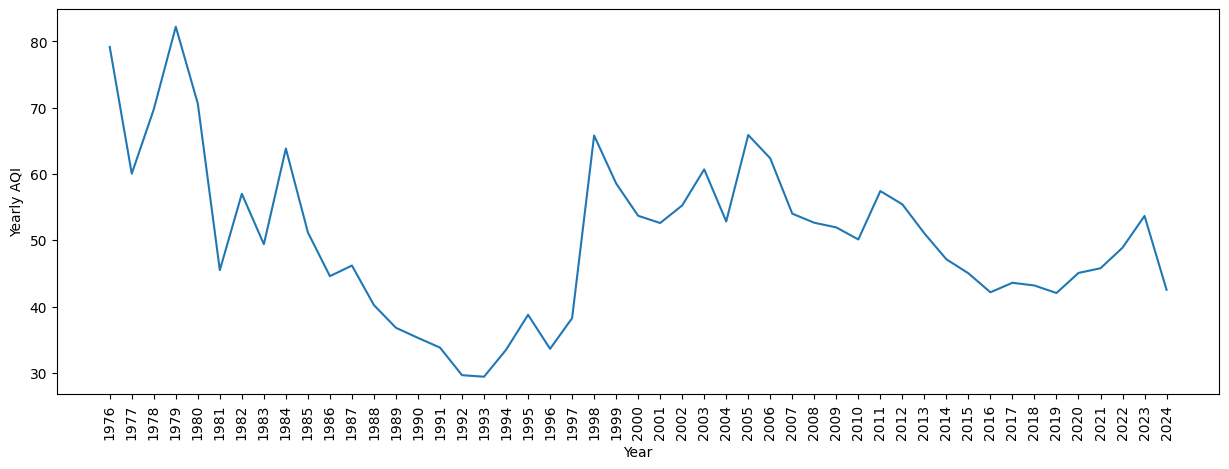

In [ ]:
# Plotting df_aqi_yearly_weighted with date_local
plt.figure(figsize=(15, 5))
df_aqi_yearly_weighted['date_local'] = df_aqi_yearly_weighted['date_local'].astype(str)
plt.plot(df_aqi_yearly_weighted["date_local"], df_aqi_yearly_weighted[0])
plt.xlabel('Year')
plt.ylabel('Yearly AQI')
plt.xticks(rotation=90)
plt.show()

Now that we have all the required values, we save our values in a CSV file.

In [ ]:
df_aqi_yearly_weighted.to_csv('df_aqi_yearly_weighted.csv')